In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv("./digit-recognizer/train.csv")
test = pd.read_csv("./digit-recognizer/test.csv")

In [3]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [4]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train=train.drop(labels = ["label"],axis = 1) 
Y_train=train['label']
print(X_train.shape)
print(Y_train.shape)

(42000, 784)
(42000,)


In [6]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [7]:
X_train=X_train.astype('float32')/255
test=test.astype('float32')/255

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [9]:
X_train.shape

(42000, 28, 28, 1)

In [10]:
test.shape

(28000, 28, 28, 1)

###  2.4 Label Encoding

In [11]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 10)

In [12]:
Y_train.shape

(42000, 10)

In [13]:
print(Y_train[:5])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


**  2.5 Now we will split training data into training data and validation data **

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)

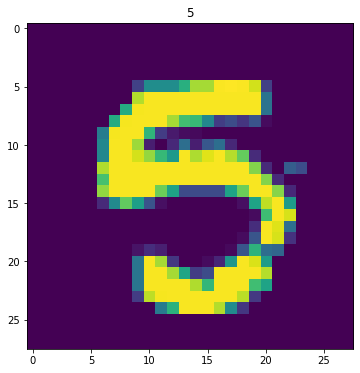

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(X_train[1][:,:,0])
plt.title(Y_train[1].argmax());

## 3.  Building CNN architecture using keras

### 3.1 Defining cnn model

In [16]:
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from keras import backend as K

In [17]:
inputShape=(28,28,1)
input = Input(inputShape)

x = Conv2D(64,(3,3),strides = (1,1),name='layer_conv1',padding='same')(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)



x = Conv2D(64,(3,3),strides = (1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)

x = Conv2D(32,(3,3),strides = (1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool3')(x)


x = Flatten()(x)
x = Dense(64,activation = 'relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(32,activation = 'relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(10,activation = 'softmax',name='fc2')(x)

model = Model(inputs = input,outputs = x,name='Predict')


In [18]:
model.summary()

Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
maxPool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256 

## 3.3 optimizer 

In [19]:
# define SGD optimizer
momentum = 0.5
sgd = SGD(lr=0.01, momentum=momentum, decay=0.0, nesterov=False) 

# compile the model
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [20]:
import math
def step_decay(epoch):
    
    
    initial_lrate=0.1
    drop=0.6
    epochs_drop = 3.0
    lrate= initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
   

lrate = LearningRateScheduler(step_decay)
callbacks_list = [ lrate]


In [21]:
history=model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),
                          epochs=3,callbacks=callbacks_list,verbose=1)

Train on 37800 samples, validate on 4200 samples
Epoch 1/3
37800/37800 [==============================] - 252s 7ms/step - loss: 0.3997 - accuracy: 0.8724 - val_loss: 0.1424 - val_accuracy: 0.9583
Epoch 2/3
37800/37800 [==============================] - 249s 7ms/step - loss: 0.1368 - accuracy: 0.9626 - val_loss: 0.0779 - val_accuracy: 0.9826
Epoch 3/3
37800/37800 [==============================] - 243s 6ms/step - loss: 0.0836 - accuracy: 0.9780 - val_loss: 0.0568 - val_accuracy: 0.9883


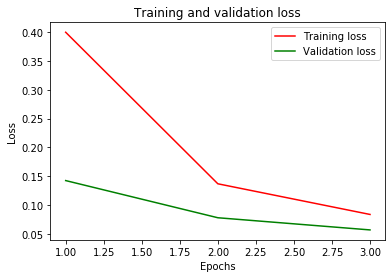

In [22]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
history.history

{'val_loss': [0.14236072434023733, 0.07787251061893975, 0.05676129663846777],
 'val_accuracy': [0.9583333134651184, 0.982619047164917, 0.9883333444595337],
 'loss': [0.3996791988029761, 0.13678524443840304, 0.08358680261805328],
 'accuracy': [0.8723545, 0.96256614, 0.97798944],
 'lr': [0.1, 0.1, 0.06]}

## 4.2 plotting training and validation accuracy

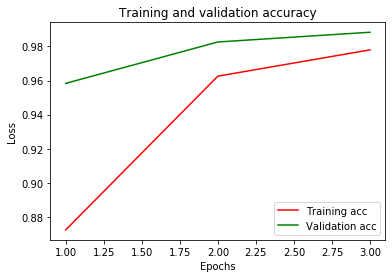

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
print("on valid data")
pred1=model.evaluate(X_valid,Y_valid)
print("accuaracy", str(pred1[1]*100))
print("Total loss",str(pred1[0]*100))

on valid data
4200/4200 [==============================] - 8s 2ms/step
accuaracy 98.83333444595337
Total loss 5.676129663846777


## Visualize CNN Layers

In [102]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[33].reshape(1,28,28,1))
acs = []
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    acs = []
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            acs.append(activation[0, :, :, activation_index])
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
    return acs

In [103]:
def hamming_distance(s1, s2):
    """Return the Hamming distance between equal-length sequences."""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length.")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

### Displaying original Image

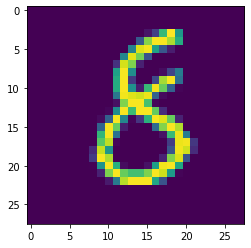

In [184]:
plt.imshow(X_train[47][:,:,0]);

# Visualizing and Analyzing the activation 3 (layer 12) for number 8 and for a traingle from seperate MNIST database

In [154]:
activations0 = activation_model.predict(X_train[15].reshape(1,28,28,1))

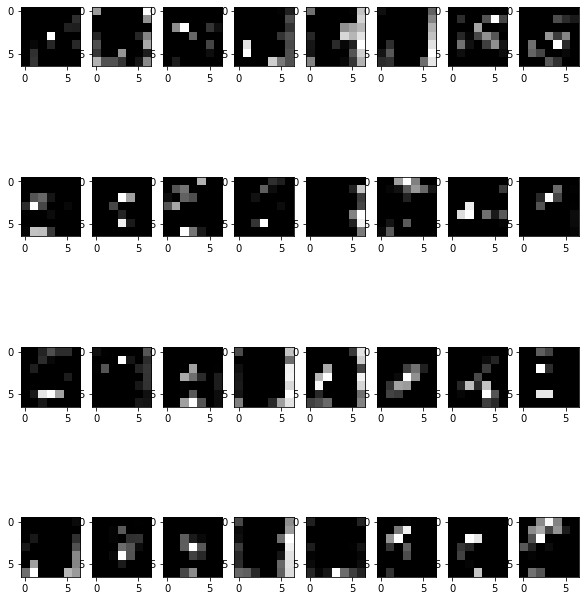

In [155]:
a0 = display_activation(activations0, 8, 4, 11)

In [156]:
len(a0)
a0_reshaped = []
for i in range(len(a0)):
    a0_reshaped.append(np.array(a0[i]).reshape(49,1))

Loading another '8' to check the difference between activation of two 8's and an '8' and Traingle

In [157]:
activations1 = activation_model.predict(X_train[33].reshape(1,28,28,1))

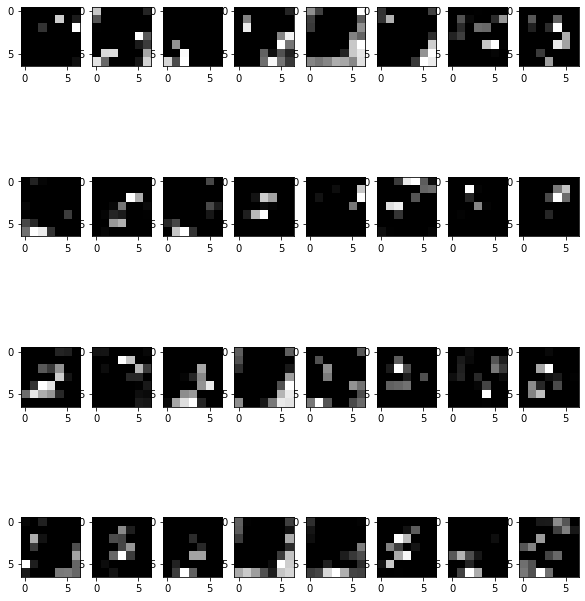

In [158]:
a1 = display_activation(activations1, 8, 4, 11)

In [159]:
len(a1)
a1_reshaped = []
for i in range(len(a1)):
    a1_reshaped.append(np.array(a1[i]).reshape(49,1))

In [160]:
from PIL import Image
import glob

image_list = glob.glob('./triangles/*.png')
x = np.array([np.array(Image.open(fname).convert('L')) for fname in image_list])
x=x.astype('float32')/255

In [161]:
model.predict(x[10].reshape(1,28,28,1))

array([[0.0845817 , 0.3284498 , 0.13793777, 0.07266806, 0.02126249,
        0.05263747, 0.02260336, 0.0939369 , 0.1579192 , 0.02800321]],
      dtype=float32)

The above result shows that the Triangle is predicted as number 8

In [162]:
activations2 = activation_model.predict(x[10].reshape(1,28,28,1))

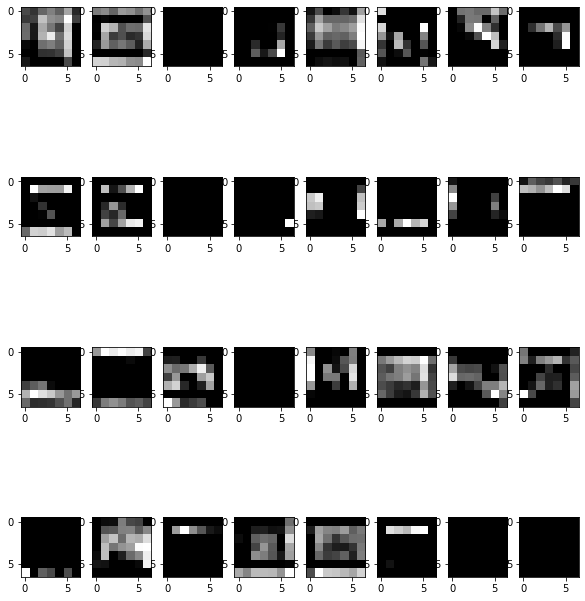

In [163]:
a2 = display_activation(activations2, 8, 4, 11)

In [164]:
a2_reshaped = []
for i in range(len(a2)):
    a2_reshaped.append(np.array(a2[i]).reshape(49,1))

Find the difference between activations of two different 8's

In [165]:
for i in range(len(a0_reshaped)-1):
    act_diff0 = a0_reshaped[i] - a1_reshaped[i]

Finding the difference between activations of an '8' and a Triangle

In [166]:
for i in range(len(a0_reshaped)-1):
    act_diff1 = a0_reshaped[i] - a2_reshaped[i]

In [167]:
np.linalg.norm(act_diff0)

4.596881

In [168]:
np.linalg.norm(act_diff1)

4.7494674

In [169]:
mmatches0 = hamming_distance(a0_reshaped, a1_reshaped)
total0 = sum(map(sum,mmatches0))
mmatches1 = hamming_distance(a0_reshaped, a2_reshaped)
total1 = sum(map(sum,mmatches1))

In [170]:
print(total0,total1)

581 757


Another Trial

In [186]:
activations3 = activation_model.predict(x[47].reshape(1,28,28,1))

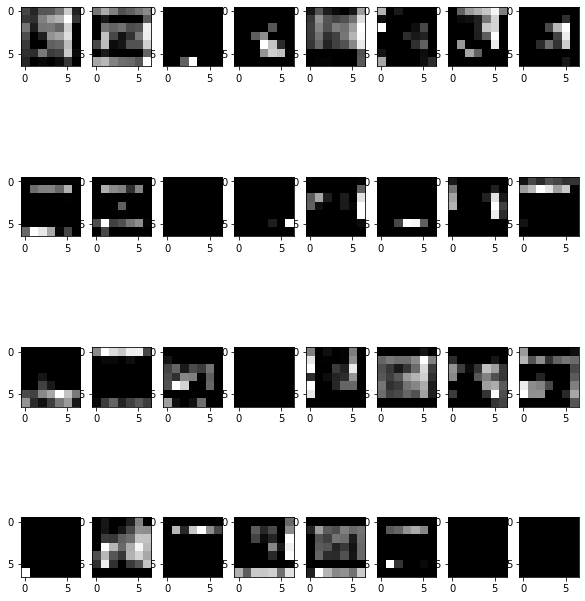

In [187]:
a3 = display_activation(activations3, 8, 4, 11)

In [189]:
a3_reshaped = []
for i in range(len(a3)):
    a3_reshaped.append(np.array(a3[i]).reshape(49,1))

In [192]:
mmatches0 = hamming_distance(a0_reshaped, a3_reshaped)
total0 = sum(map(sum,mmatches0))
mmatches1 = hamming_distance(a0_reshaped, a2_reshaped)
total1 = sum(map(sum,mmatches1))

In [193]:
print(total0,total1)

766 757


# Visualizing and Analyzing the activation 2 (layer 8) for number 8 and for a traingle from seperate MNIST database

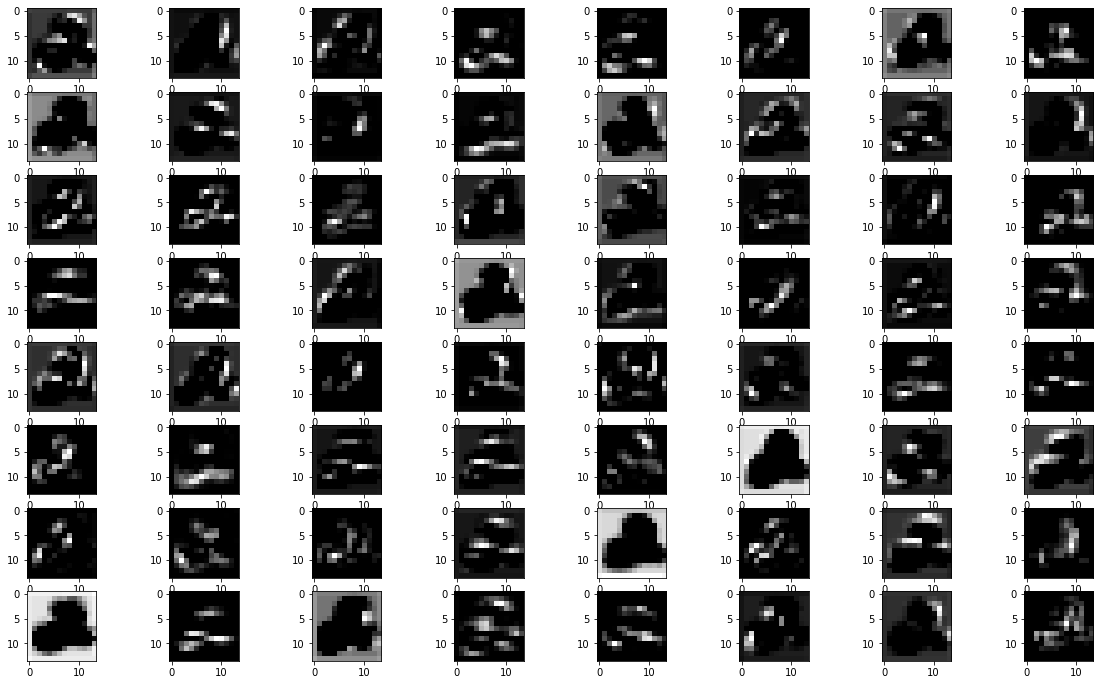

In [122]:
a0_1 = display_activation(activations0, 8, 8, 7)

In [123]:
len(a0_1)
a0_1_reshaped = []
for i in range(len(a0_1)):
    a0_1_reshaped.append(np.array(a0_1[i]).reshape(196,1))

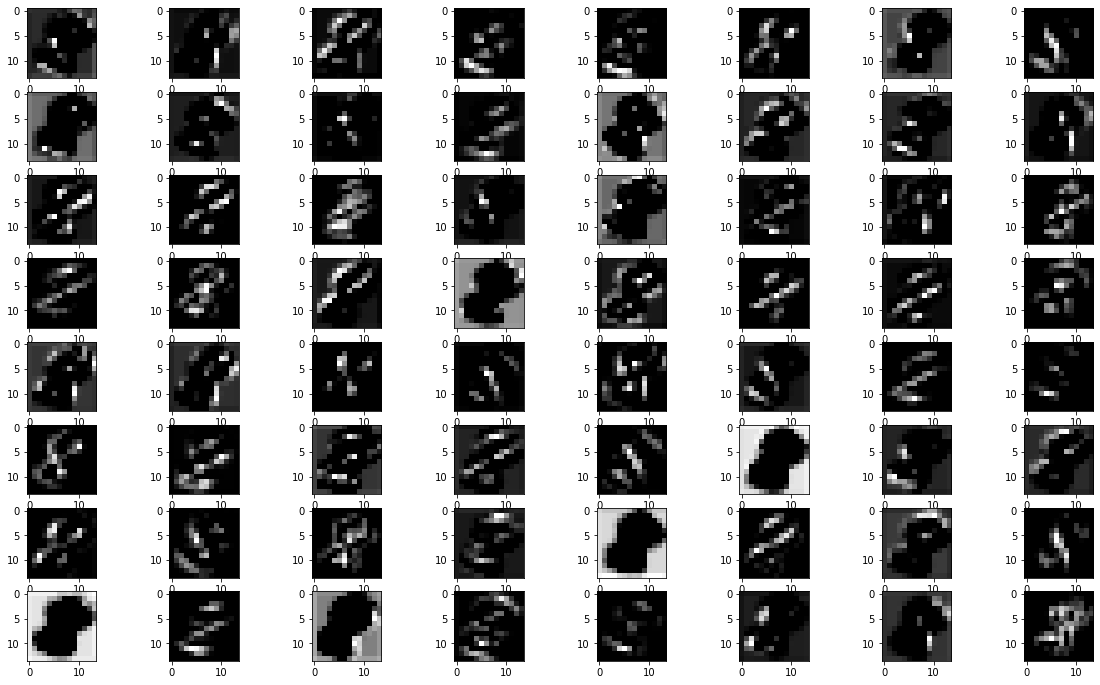

In [124]:
a1_1 = display_activation(activations1, 8, 8, 7)

In [125]:
len(a1_1)
a1_1_reshaped = []
for i in range(len(a1_1)):
    a1_1_reshaped.append(np.array(a1_1[i]).reshape(196,1))

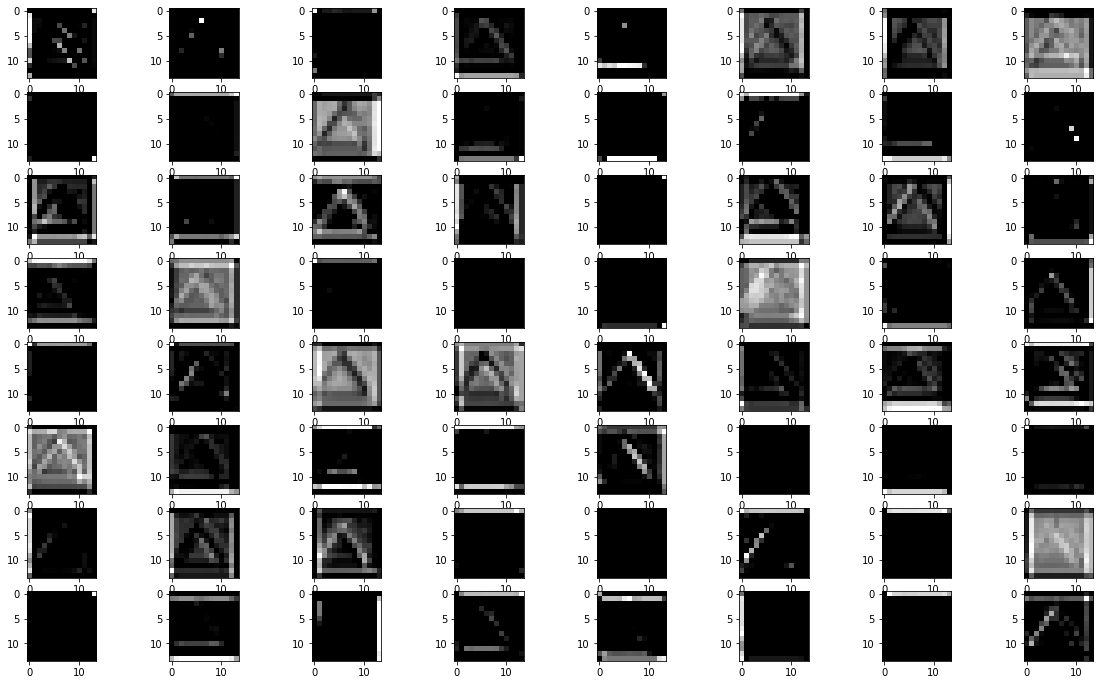

In [126]:
a2_1 = display_activation(activations2, 8, 8, 7)

In [127]:
# a2_1_reshaped = a2_1.flatten()

a2_1_reshaped = []
for i in range(len(a2_1)):
    a2_1_reshaped.append(np.array(a2_1[i]).reshape(196,1))

In [132]:
mmatches0_1 = hamming_distance(a0_1_reshaped, a1_1_reshaped)
total0_1 = sum(map(sum,mmatches0_1))
mmatches1_1 = hamming_distance(a0_1_reshaped, a2_1_reshaped)
total1_1 = sum(map(sum,mmatches1_1))

In [133]:
print(total0_1,total1_1)

5903 8428
